# Environments
In this notebook we will show four methods for incorporating new SimulatedEnvironments into Coba:
1. From an Openml.org dataset with **OpenmlSimulation**
2. From local data sets with **CsvSimulation**, **ArffSimulation**, **LibsvmSimulation**, and **ManikSimulation**.
3. From Python function definitions with **LambdaSimulation**
4. From your own class that implements the **SimulatedEnvironment** interface

## Environments From Openml.org

Perhaps the easiest way to incorporate new Environments is to load them from Openml.org. Openml is is an online repository of machine learning data sets which currently hosts over 21,000 datasets. Using dataset ids Coba can tap into this repository and download these datasets to create Environments.

To get a sense of how this works let's say we want to build a SimulatedEnvironment from the Covertype data set. We can [do a dataset search](https://www.openml.org/search?type=data) on Openml.org to see if this data set is hosted. [This search](https://www.openml.org/search?q=covertype&type=data) finds several data sets and we simply pick [the first one](https://www.openml.org/d/180). On the dataset's landing page we can look at the URL -- https://www.openml.org/d/180 -- to get the dataset's id of 180. Now, all we have to do to run an experiment with the Covertype data set is:


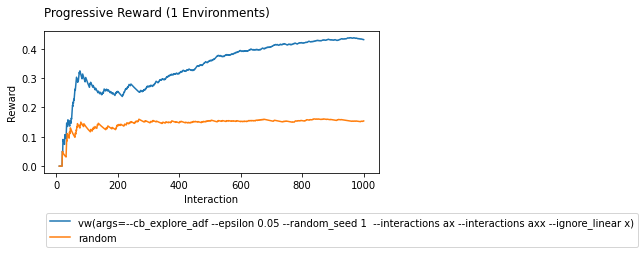

In [15]:
import coba as cb

environments = cb.Environments.cache_dir('.coba_cache').from_openml(180,take=1000).shuffle(n=1)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners(xlim=(10,None))

This same procedure can be repeated for any dataset on Openml.org.

## Simulated Environments From Local Datasets

The next easiest way to incorporate new environments is to load them from a local dataset. Coba can create SimulatedEnvironments from datasets in the following formats:
* CSV
* ARFF (i.e., https://waikato.github.io/weka-wiki/formats_and_processing/arff_stable/)
* Libsvm (e.g., https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html)
* Manik (e.g., http://manikvarma.org/downloads/XC/XMLRepository.html)

For example, we may want to test against an arff version of the iris dataset. 


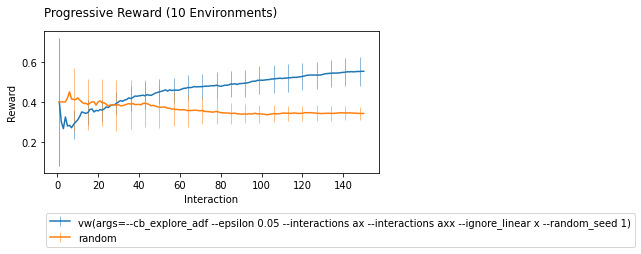

In [2]:
import coba as cb

environments = cb.Environments.from_supervised(cb.ArffSource("iris.arff"), label_col='Species').shuffle(n=10)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners(err='se')


The complete list of supported sources for local supervised data is:

* `CsvSource(source:str, with_header:bool=True)`
* `ArffSource(source:str, cat_as_str:bool=False)`
* `LibSvmSource(source:str)`
* `ManikSource(source:str)`

## Environments from Function Definitions

A third method for creating environments for use in experiments is via function definitions. 

This can be done with **LambdaSimulation** which takes three function definitions -- describing how to generate contexts, actions and rewards -- and the number of interactions you'd like the environment to have. An example of a **LambdaSimulation** generating random contexts and actions with a linear reward function in [0,1] is provided:


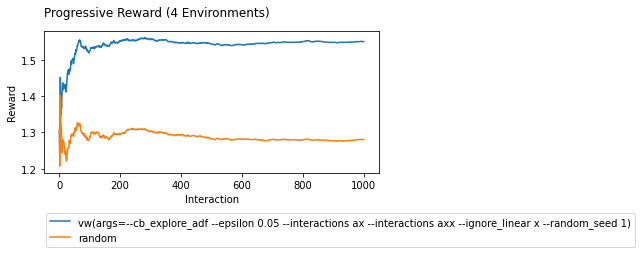

In [3]:
import coba as cb

context = lambda index,rng               : rng.randoms(5)
actions = lambda index,context,rng       : [rng.randoms(5) for _ in range(3)]
rewards = lambda index,context,action,rng: sum(c*a for c,a in zip(context,action))

environments = cb.Environments.from_lambda(1000, context, actions, rewards, 1).shuffle(n=4)
learners     = [cb.VowpalEpsilonLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners()

## Environments from Scratch

The final, and most involved method, for creating new SimulatedEnvironments in Coba is to create your own from scratch. This might be needed if you need to ingest a format that Coba doesn't already support. Or maybe you need your environment to track some internal state between interactions. By creating your own Simulation there really is no limit to the functionality employed. In order to make your own environment you need to implement the SimulatedEnvironment interface.


### SimulatedEnvironment Interface

A SimulatedEnvironment in Coba is any class with the following interface:

```python
class SimulatedEnvironment:

    @abstractmethod
    def read(self) -> Iterable[SimulatedInteraction]:
        """The sequence of interactions in the environment.

        Remarks:
            This function should always be "re-iterable".
        """
        ...
    
```

So long as your class satisfies this interface it should be completely interoperable with Coba. Below is an example:

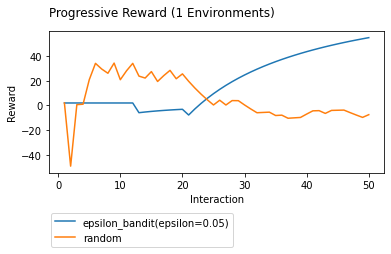

In [3]:
import coba as cb

class MyEnvironment:    
    def read(self):
        for i in range(50):
            yield cb.SimulatedInteraction(context=None, actions=[1,2,3], rewards=[2,100,-100])

environments = MyEnvironment()
learners     = [cb.EpsilonBanditLearner(),cb.RandomLearner()]
experiment   = cb.Experiment(environments, learners)

experiment.run(quiet=True).plot_learners()